# Seq2Seq

1. Encoder 구현
2. Decoder 구현
3. Seq2Seq 모델을 구축하고 사용합니다.

 ## 라이브러리


In [2]:
from tqdm import tqdm
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch
import random

## 데이터 전처리

`src_data` 를 `trg_data` 로 바꾸는 task를 수행하기 위한 sample data 입니다.  
전체 단어수는 100개이고 다음과 같이 pad_token, start_token, end_token의 id도 정의합니다.

In [3]:
vocab_size = 100
pad_id = 0
sos_id = 1
eos_id = 2

src_data = [
  [3, 77, 56, 26, 3, 55, 12, 36, 31],
  [58, 20, 65, 46, 26, 10, 76, 44],
  [58, 17, 8],
  [59],
  [29, 3, 52, 74, 73, 51, 39, 75, 19],
  [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93],
  [39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99, 5],
  [75, 34, 17, 3, 86, 88],
  [63, 39, 5, 35, 67, 56, 68, 89, 55, 66],
  [12, 40, 69, 39, 49]
]

trg_data = [
  [75, 13, 22, 77, 89, 21, 13, 86, 95],
  [79, 14, 91, 41, 32, 79, 88, 34, 8, 68, 32, 77, 58, 7, 9, 87],
  [85, 8, 50, 30],
  [47, 30],
  [8, 85, 87, 77, 47, 21, 23, 98, 83, 4, 47, 97, 40, 43, 70, 8, 65, 71, 69, 88],
  [32, 37, 31, 77, 38, 93, 45, 74, 47, 54, 31, 18],
  [37, 14, 49, 24, 93, 37, 54, 51, 39, 84],
  [16, 98, 68, 57, 55, 46, 66, 85, 18],
  [20, 70, 14, 6, 58, 90, 30, 17, 91, 18, 90],
  [37, 93, 98, 13, 45, 28, 89, 72, 70]
]

각각의 데이터를 전처리합니다.

In [4]:
trg_data = [[sos_id] + seq + [eos_id] for seq in tqdm(trg_data)]

100%|██████████| 10/10 [00:00<00:00, 113975.65it/s]


In [6]:
trg_data[0]

[1, 75, 13, 22, 77, 89, 21, 13, 86, 95, 2]

In [7]:
def padding(data, is_src=True):
    max_len = len(max(data, key = len))
    print(f"Maximum sequence length: {max_len}")
    
    valid_lens = []
    for i, seq in enumerate(tqdm(data)):
        valid_lens.append(len(seq))
        if len(seq) < max_len:
            data[i] = seq + [pad_id] * (max_len - len(seq))
            
    return data, valid_lens, max_len
    # 패딩된 데이터, 각 원본 길이(to torch..pack_padded.), 최대 길이

In [8]:
src_data, src_lens, src_max_len = padding(src_data)
trg_data, trg_lens, trg_max_len = padding(trg_data)

100%|██████████| 10/10 [00:00<00:00, 169809.88it/s]

Maximum sequence length: 15
Maximum sequence length: 22


In [15]:
# B: batch size
# S_L : source maximum sequence length
# T_L : target maximum sequence length

# 전체를 하나의 배치로 

src_batch = torch.LongTensor(src_data) # (B, S_L)
src_batch_lens = torch.LongTensor(src_lens) # (B)
trg_batch = torch.LongTensor(trg_data) # (B, T_L)
trg_batch_lens = torch.LongTensor(trg_lens) # (B)

print(src_batch.size())
print(src_batch_lens.size())
print(trg_batch.size())
print(trg_batch_lens.size())

torch.Size([10, 15])
torch.Size([10])
torch.Size([10, 22])
torch.Size([10])


PackedSequence 사용을 위해 source data를 기준으로 정렬합니다.

In [16]:
src_batch_lens, sorted_idx = src_batch_lens.sort(descending=True)
src_batch = src_batch[sorted_idx]
trg_batch = trg_batch[sorted_idx]
trg_batch_lens = trg_batch_lens[sorted_idx]

# tensor.sort() : values, index 두 개 출력

print(src_batch)
print(src_batch_lens)
print(trg_batch)
print(trg_batch_lens)

tensor([[39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99,  5],
        [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93,  0,  0,  0,  0],
        [63, 39,  5, 35, 67, 56, 68, 89, 55, 66,  0,  0,  0,  0,  0],
        [ 3, 77, 56, 26,  3, 55, 12, 36, 31,  0,  0,  0,  0,  0,  0],
        [29,  3, 52, 74, 73, 51, 39, 75, 19,  0,  0,  0,  0,  0,  0],
        [58, 20, 65, 46, 26, 10, 76, 44,  0,  0,  0,  0,  0,  0,  0],
        [75, 34, 17,  3, 86, 88,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [12, 40, 69, 39, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [58, 17,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [59,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
tensor([15, 11, 10,  9,  9,  8,  6,  5,  3,  1])
tensor([[ 1, 37, 14, 49, 24, 93, 37, 54, 51, 39, 84,  2,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 1, 32, 37, 31, 77, 38, 93, 45, 74, 47, 54, 31, 18,  2,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 1, 20, 70, 14,  6, 58, 90,

## Encoder 구현

In [17]:
embedding_size = 256
hidden_size = 512
num_layers = 2
num_dirs = 2
dropout = 0.1

Bidirectional GRU를 이용한 Encoder
* `self.embedding` : word embedding layer
* `self.gru` : encoder 역할을 하는 Bi-GRU
* `self.linear` : 양/단방향 concat 된 hidden state 를 decoder 의 hidden size 에 맞게 linear transformation  
(decoder 는 단방향이기 때문에 bidirectional 을 거친 층을 맞춰주기 위해 linear 층 설정)

In [34]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(
            input_size = embedding_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            bidirectional = True if num_dirs > 1 else False,
            dropout = dropout
        )
        self.linear = nn.Linear(num_dirs * hidden_size , hidden_size)
        
        # forward 순서
        # 1. embedding 후 transpose 후 학습 할 수 있게 packing
        # 2. encoder gru 통과 : input, hidden_0 (여기서는 한 층이나, 본래 단어 단위로 gru 층마다 넣어준다.)
        # 3. un_packing (to tensor)
        # 4. decoder 주입용 hidden vector 추출 : bidirectional 이므로 마지막 벡터 -2, -1(양방향)
          # bi : forward 방향 gru hidden , backward 방향 gru hidden
        # 5. 두 정보를 담고 있는 hidden vectors 들을 하나로 압축 : linear 선형 변환
        
    def forward(self, batch, batch_lens):
        # batch : (B, S_L), batch_lens : (B)
        # d_w : word embedding size
        batch_emb = self.embedding(batch) #(B, S_L, d_w)
        batch_emb = batch_emb.transpose(0,1) # (S_L, B, d_w)
        
        packed_input = pack_padded_sequence(batch_emb, batch_lens) 
        # batch_lens = src_batch_lens
        # tensor([15, 11, 10,  9,  9,  8,  6,  5,  3,  1])
        h_0 = torch.zeros((num_layers * num_dirs, batch.shape[0], hidden_size))
        # (num_layers*num_dirs, B, d_h) = (4, B, d_h)
        # hidden vector 사이즈와 동일한 hidden vector 초기값
        packed_outputs, h_n = self.gru(packed_input, h_0)
        # h_n : (4, B, d_h)
        outputs = pad_packed_sequence(packed_outputs)[0]
        # outputs : (S_L, B, 2d_h)
        
        forward_hidden = h_n[-2, :, :]
        backward_hidden = h_n[-1, :, :]
        hidden = self.linear(torch.cat((forward_hidden, backward_hidden), dim=-1)).unsqueeze(0)
        # (1, B, d_h)
        
        return outputs, hidden
        # 여기서는 hidden state vector 만 중요

In [35]:
encoder = Encoder()

## Decoder 구현

동일한 설정의 Bi-GRU 로 만든 Decoder 입니다.
* `self.embedding` : word embedding layer
* `self.gru` : decoder 역할을 하는 Bi_GRU
* `self.output_layer` : decoder 에서 나온 hidden state 를 `vocab_size` 로 linear transformation 하는 layer

In [28]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(
             input_size = embedding_size,
             hidden_size = hidden_size
        )
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, batch, hidden): # batch: (B), hidden: (1, B, d_h)
        batch_emb = self.embedding(batch) # (B, d_w)
        batch_emb = batch_emb.unsqueeze(0) # (1, B, d_w)
        
        outputs, hidden = self.gru(batch_emb, hidden)
        # outputs : (1, B, 2d_h), hidden : (1, B, d_h)
        
        # V : vocab size
        outputs = self.output_layer(outputs) # (1,B,V)
        return outputs.squeeze(0), hidden

In [29]:
decoder = Decoder()

# Seq2Seq 모델 구축

생성한 encoder 와 decoder 를 합쳐 Seq2Seq 모델을 구축합니다.
* `self.encoder` : encoder
* `self.decoder` : decoder

In [39]:
class Seq2seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src_batch, src_batch_lens, trg_batch, teacher_forcing_prob=0.5):
        # src_batch : (B, S_L)
        # src_batch_lens : (B)
        # trg_batdh : (B, T_L)
        _, hidden = self.encoder(src_batch, src_batch_lens)
        # hidden : (1, B, d_h)
        
        input_ids = trg_batch[:, 0] # (B) 
        # decoder 에서 한단어씩 생성하기 때문에, 첫단어를 주입
        batch_size = src_batch.shape[0]
        outputs = torch.zeros(trg_max_len, batch_size, vocab_size)
        # (T_L, B, V)
        
        for t in range(1, trg_max_len):
            decoder_outputs, hidden = self.decoder(input_ids, hidden)
            # decoder_outputs : (B, V), hidden : (1, B, d_H)
            
            outputs[t] = decoder_outputs
            _, top_ids = torch.max(decoder_outputs, dim=-1)
            # top_ids : (B)

            input_ids = trg_batch[:, t] if random.random() > teacher_forcing_prob else top_ids
            
        return outputs

In [40]:
seq2seq = Seq2seq(encoder, decoder)

## 모델 사용해보기

학습 과정이라고 가정하고 모델에 input 을 넣어봅니다.

In [41]:
outputs = seq2seq(src_batch, src_batch_lens, trg_batch)

print(outputs)
print(outputs.shape)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0986, -0.1136,  0.0275,  ..., -0.0260, -0.0677,  0.0501],
         [ 0.0640, -0.1818, -0.0187,  ..., -0.0528, -0.0444,  0.0319],
         [ 0.0767, -0.1089, -0.0008,  ...,  0.0202, -0.0889,  0.0550],
         ...,
         [ 0.0518, -0.1582, -0.0165,  ..., -0.0586, -0.0740,  0.0365],
         [ 0.0699, -0.1259,  0.0130,  ..., -0.0063, -0.0546,  0.0759],
         [ 0.0817, -0.1376, -0.0119,  ..., -0.0361, -0.0526,  0.0731]],

        [[ 0.0736, -0.1202,  0.0748,  ...,  0.0635, -0.0899, -0.2654],
         [-0.0754, -0.1762,  0.0029,  ..., -0

Language Modeling 에 대한 loss 계산을 위해 shift 한 target 과 비교합니다.

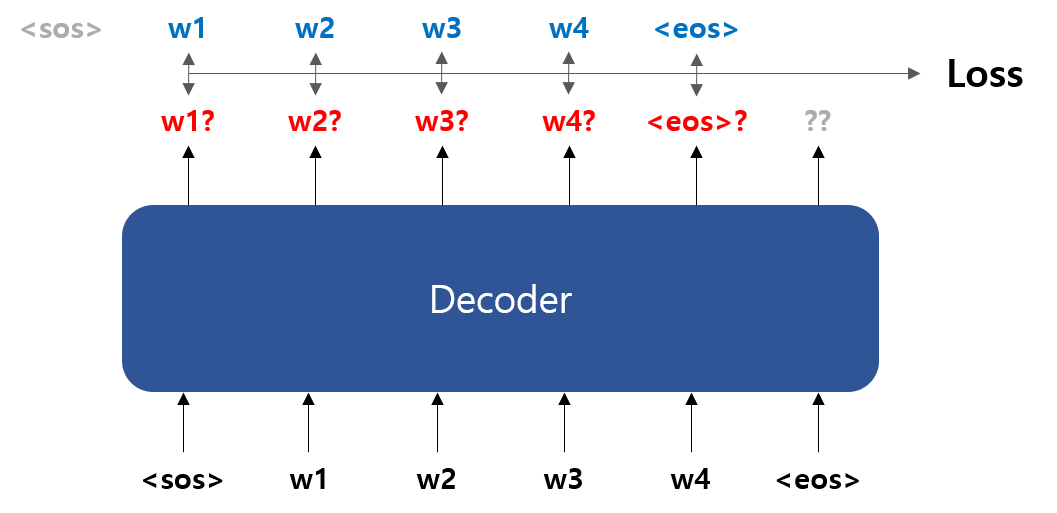

In [44]:
loss_function = nn.CrossEntropyLoss()

preds = outputs[1:, :, :].transpose(0,1) # (B, T_L-1, V)
loss = loss_function(preds.contiguous().view(-1, vocab_size), 
                     trg_batch[:,1:].contiguous().view(-1, 1).squeeze(1))
print(loss)

tensor(4.6085, grad_fn=<NllLossBackward>)


실제 inference 에선 teacher forcing 없이 이전 결과만을 가지고 생성합니다.

In [48]:
src_sent = [4, 10, 88, 46, 72, 34, 14, 51]
src_len = len(src_sent)

src_batch = torch.LongTensor(src_sent).unsqueeze(0) # (1, L)
src_batch_lens = torch.LongTensor([src_len]) # (1)

_, hidden = seq2seq.encoder(src_batch, src_batch_lens) # hidden : (1, 1, d_h)

In [50]:
input_id = torch.LongTensor([sos_id]) # (1)
output = []

for t in range(1, trg_max_len):
    decoder_output, hidden = seq2seq.decoder(input_id, hidden)  # decoder_output: (1, V), hidden: (1, 1, d_h)

    _, top_id = torch.max(decoder_output, dim=-1)  # top_ids: (1)

    if top_id == eos_id:
        break
    else:
        output += top_id.tolist()
        input_id = top_id

In [52]:
print(output)

[83, 3, 64, 41, 23, 3, 66, 66, 66, 71, 80, 92, 23, 9, 14, 76, 76, 30, 76, 30, 58]
